In [1]:
%load_ext autoreload
%autoreload 2

import auxiliary.util as util
import auxiliary.grid2op_util as g2o_util
import numpy as np
import os

import pandas as pd
import ipdb
import matplotlib.pyplot as plt

import grid2op
import re
import data_preprocessing_analysis.imitation_data_preprocessing as idp
import functools
from auxiliary.generate_action_space import action_identificator
import json
import math
from sklearn.metrics import confusion_matrix
from pathlib import Path
import collections
from scipy.stats import entropy
from scipy.spatial import distance
from tqdm import tqdm
from collections import Counter

In [2]:
util.set_wd_to_package_root()
config = util.load_config()
processed_data_path = config['paths']['processed_tutor_imitation']
con_matrix_path = config['paths']['con_matrix_cache']
fstats_path = config['paths']['feature_statistics']

line_disabled_to_consider = [-1,0,1,2,3,4,5,6,10,12,13,15,16,19]
line_group1 = [-1,0,1,2,3,4,5,6,12]
line_group2 = [13,15,16,19]

# Processed Data Analysis

In [3]:
counters = {} 
hash_to_act = {}
hash_to_res = {}
hash_to_tv = {}
n_sub = 14

for i in np.arange(-1,20):
    counters[i] = {
        'n_datapoints':0,
        'n_days_completed':0,
        'n_chronics':0,
        'set_hash': collections.Counter(),
        'res_hash': collections.Counter(),
        'tv_hash': collections.Counter(),
        'sub_changed': (n_sub+1) * [0],
        'changed_subs_n': n_sub * [0],
        'sub_info': []
    }
        
        

for f in tqdm(list(Path(processed_data_path).rglob('*.json'))):
    with open(f, 'r') as file:
            dps = json.loads(file.read())
            
    line_disabled = dps[0]['line_disabled']
    
    counters[line_disabled]['n_chronics']+=1
    counters[line_disabled]['n_days_completed']+=dps[0]['dayscomp']
    for dp in dps:
        #Increase n. datapoints
        counters[line_disabled]['n_datapoints']+=1
        
        #Count set_topo_vect
        hsh_set = util.hash_nparray(np.array(dp['set_topo_vect']))
        if hsh_set not in hash_to_act:
            hash_to_act[hsh_set] = dp['set_topo_vect']
        counters[line_disabled]['set_hash'][hsh_set]+=1
        
        #Count res_topo_vect
        hsh_res = util.hash_nparray(np.array(dp['res_topo_vect']))
        if hsh_res not in hash_to_res:
            hash_to_res[hsh_res] = dp['res_topo_vect']
        counters[line_disabled]['res_hash'][hsh_res]+=1
        
        #Count topo_vect
        hsh_tv = util.hash_nparray(np.array(dp['topo_vect']))
        if hsh_tv not in hash_to_tv:
            hash_to_tv[hsh_tv] = dp['topo_vect']
        counters[line_disabled]['tv_hash'][hsh_tv]+=1
        
        #Count substations affected
        action_per_sub = g2o_util.tv_groupby_subst(dp['set_topo_vect'],dp['sub_info'])
        try:
            changed_subs_id = [np.any(a) for i,a in enumerate(action_per_sub)].index(True)
            counters[line_disabled]['sub_changed'][changed_subs_id] += 1
        except:
            counters[line_disabled]['sub_changed'][-1] += 1

        #Count topological depth of resulting topologies
        #ASSUMPTION: reference topology is the topology where all objects are connected to bus 1
        res_per_sub = g2o_util.tv_groupby_subst(dp['res_topo_vect'],dp['sub_info'])
        changed_subs_n = sum([2 in res for i,res in enumerate(res_per_sub)])
        counters[line_disabled]['changed_subs_n'][changed_subs_n] += 1
        
        #Set sub info
        counters[line_disabled]['sub_info'] = dp['sub_info']


100%|██████████| 1000/1000 [00:10<00:00, 96.92it/s]


#### Number of chronics

In [4]:
sum([v['n_chronics']for k,v in counters.items() if k in line_disabled_to_consider])

1000

#### Percentage days completed

In [5]:
print([(k,v['n_days_completed']/(28*v['n_chronics'])) if v['n_chronics']!=0 else None
       for k,v in counters.items() 
       if k in line_disabled_to_consider])

[(-1, 0.9973214285714286), None, None, None, None, None, None, None, None, None, None, None, None, None]


In [6]:
print('Total:',
    sum([v['n_days_completed']for k,v in counters.items() if k in line_disabled_to_consider])/ \
    sum([28*v['n_chronics']for k,v in counters.items() if k in line_disabled_to_consider]))
print('Group 1:',
    sum([v['n_days_completed']for k,v in counters.items() if k in line_group1])/ \
    sum([28*v['n_chronics']for k,v in counters.items() if k in line_group1]))
print('Group 2:',
    sum([v['n_days_completed']for k,v in counters.items() if k in line_group2])/ \
    sum([28*v['n_chronics']for k,v in counters.items() if k in line_group2]))

Total: 0.9973214285714286
Group 1: 0.9973214285714286


ZeroDivisionError: division by zero

#### Number of datapoints

In [7]:
[(k,v['n_datapoints'])for k,v in counters.items() if k in line_disabled_to_consider]

[(-1, 25993),
 (0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (10, 0),
 (12, 0),
 (13, 0),
 (15, 0),
 (16, 0),
 (19, 0)]

In [8]:
N_total = sum([v['n_datapoints']for k,v in counters.items() if k in line_disabled_to_consider])
N_group1 = sum([v['n_datapoints']for k,v in counters.items() if k in line_group1])
N_group2 = sum([v['n_datapoints']for k,v in counters.items() if k in line_group2])

print('Total:', N_total)
print('Group 1:', N_group1)
print('Group 2:', N_group2)

Total: 25993
Group 1: 25993
Group 2: 0


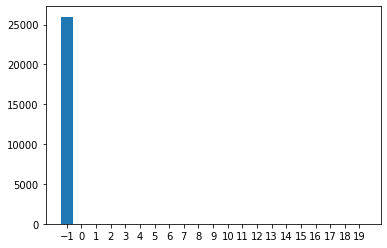

In [9]:
plt.bar(line_disabled_to_consider,
        [counters[l]['n_datapoints'] for l in np.arange(-1,20) if l in line_disabled_to_consider])
ax = plt.gca()
_ = ax.set_xticks(np.arange(-1,20))

#### Action statistics

Number of actions

In [10]:
[(k,len(v['set_hash']))
 for k,v in counters.items() 
 if k in line_disabled_to_consider]

[(-1, 74),
 (0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (10, 0),
 (12, 0),
 (13, 0),
 (15, 0),
 (16, 0),
 (19, 0)]

Percentage of do-nothing actions

In [11]:
#Find the hashes that are do-nothing actions. Should not be higher than two. 
do_nothing_action_hashes = [h for h,t 
                            in hash_to_act.items() 
                            if sum(t)==0]
assert len(do_nothing_action_hashes) < 3

[(k,sum([v['set_hash'][h] for h in do_nothing_action_hashes])/v['n_datapoints'])
 for k,v in counters.items() 
 if k in line_disabled_to_consider and v['n_datapoints'] != 0]

[(-1, 0.07151925518408803)]

In [12]:
sum([sum([v['set_hash'][h] for h in do_nothing_action_hashes])
          /v['n_datapoints']
         for k,v in counters.items() 
         if k in line_disabled_to_consider and v['n_datapoints'] != 0])/N_total

2.751481367448468e-06

In [13]:
print('Total:',
     sum([sum([v['set_hash'][h] for h in do_nothing_action_hashes])
         for k,v in counters.items() 
         if k in line_disabled_to_consider and v['n_datapoints'] != 0])/N_total)
print('Group 1:',
     sum([sum([v['set_hash'][h] for h in do_nothing_action_hashes])
         for k,v in counters.items() 
         if k in line_group1 and v['n_datapoints'] != 0])/N_group1)
print('Group 2:',
     sum([sum([v['set_hash'][h] for h in do_nothing_action_hashes])
         for k,v in counters.items() 
         if k in line_group2 and v['n_datapoints'] != 0])/N_group2)

Total: 0.07151925518408803
Group 1: 0.07151925518408803


ZeroDivisionError: division by zero

Entropy of the action distribution

In [14]:
[(k,entropy(list(v['set_hash'].values()))) 
 for k,v in counters.items() 
 if k in line_disabled_to_consider]

[(-1, 2.511363531402685),
 (0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (10, 0.0),
 (12, 0.0),
 (13, 0.0),
 (15, 0.0),
 (16, 0.0),
 (19, 0.0)]

In [15]:
#Getting actions into format so that actions at substations
standard_sub_info = [3, 6, 4, 6, 5, 6, 3, 2, 5, 3, 3, 3, 4, 3]
    
for i in np.arange(-1,20):
    act_counter = counters[i]['set_hash']
    unique_act_counter = collections.Counter()
    for h,c in act_counter.items():
        a = hash_to_act[h]
        a_per_substation = g2o_util.tv_groupby_subst(a,counters[i]['sub_info'])
        try:
            changed_subs_id = [np.any(a) for a in a_per_substation].index(True)
            action = (changed_subs_id,tuple(a_per_substation[changed_subs_id]),
                      None if standard_sub_info[changed_subs_id]==counters[i]['sub_info'][changed_subs_id] else i)
            unique_act_counter[action] += c
        except ValueError:
            unique_act_counter[-1] += c
    counters[i]['unique_set_act'] = unique_act_counter
    
combined_act_counter = collections.Counter()
act_counter_group1 = collections.Counter()
act_counter_group2 = collections.Counter()
for i in np.arange(-1,20):
    combined_act_counter = combined_act_counter + counters[i]['unique_set_act']
    if i in line_group1:
        act_counter_group1 += act_counter_group1 + counters[i]['unique_set_act']
    elif  i in line_group2:
        act_counter_group2 += act_counter_group2 + counters[i]['unique_set_act']
        

In [16]:
tups = list(combined_act_counter.keys())
tups = sorted([t for t in tups if type(t)==tuple])
tups = [-1] + tups
tups

colormap = {
    -1:'k',
    1:'b',
    2:'g',
    3:'r',
    4:'c',
    5:'m',
    8:'y',
    12:'k',
}

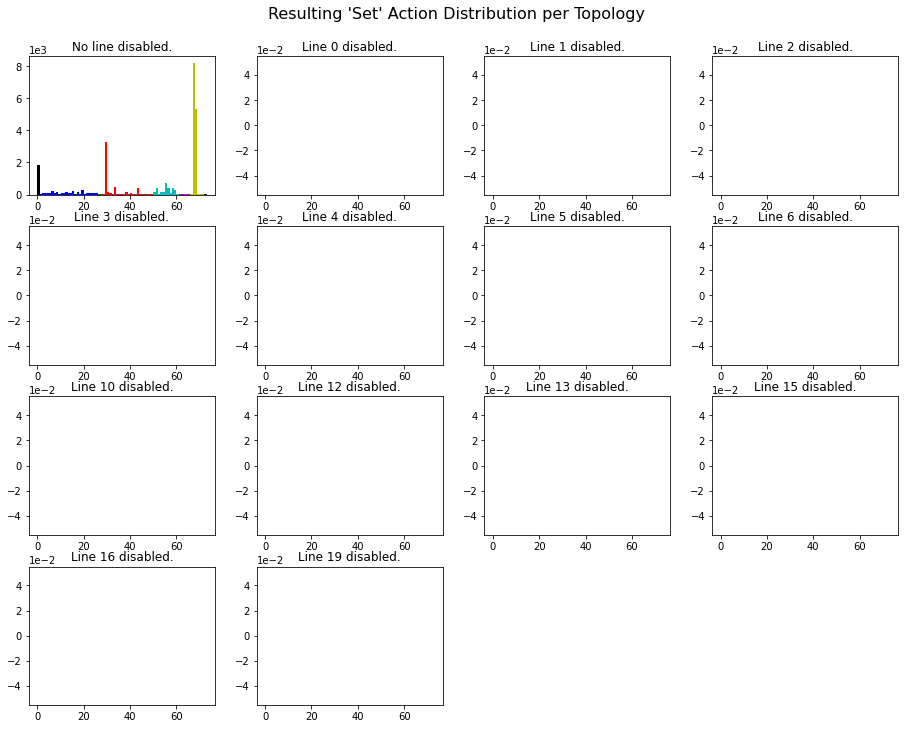

In [17]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
axs = axs.reshape(-1)
fig.tight_layout()

for plt_i, c_i in enumerate(line_disabled_to_consider):
    act_counter = counters[c_i]['unique_set_act']
    weight = [act_counter[i] for i in tups]

    _, _, patches = axs[plt_i].hist(range(len(weight)), weights=weight,bins=range(len(weight)))
    axs[plt_i].title.set_text(f'Line {c_i} disabled.' if c_i>-1 else 'No line disabled.')
    
    #Applying colors
    for j,t in enumerate(tups[:-1]):
        if type(t) == int:
            continue
        patches[j].set_facecolor(colormap[t[0]])
    patches[0].set_facecolor(colormap[-1])
    
    axs[plt_i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

for i in range(len(axs)-len(line_disabled_to_consider)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Resulting \'Set\' Action Distribution per Topology', fontsize=16, y=1.05)
fig.savefig('data_preprocessing_analysis/figures/action_distribution_per_topology.png', dpi=300)

In [18]:
counters[-1]['set_hash'].most_common()

[(5216975167053005761, 8226),
 (8937131061687177940, 5343),
 (-1221862190638690505, 3258),
 (-5647247916322209430, 1859),
 (-3203449544983759407, 747),
 (-5371662114248039143, 480),
 (8201703258021292577, 435),
 (1889465080037953788, 400),
 (4877112017131333062, 399),
 (-6096904296072924821, 395),
 (-482555509848347048, 293),
 (8801576801771102413, 254),
 (5558496938283834350, 246),
 (-6727039530836274399, 241),
 (-3439126676075770935, 163),
 (-1866006640930039802, 158),
 (-6395368471185718686, 153),
 (-8462840797199359110, 141),
 (1800196816847210972, 136),
 (1440748049527266414, 135),
 (4530103322421583507, 130),
 (-6640679792867691398, 128),
 (-8555551815801419114, 123),
 (-9183113138760251854, 119),
 (-7600887518365576667, 117),
 (6472221066818058302, 108),
 (-2536440255128613188, 105),
 (-5054213541080857801, 104),
 (5013510431674209232, 93),
 (7248646025302698985, 92),
 (787373484356923030, 89),
 (-5435990713431008279, 79),
 (-3742960266356351600, 76),
 (-3655097045691593271, 75)

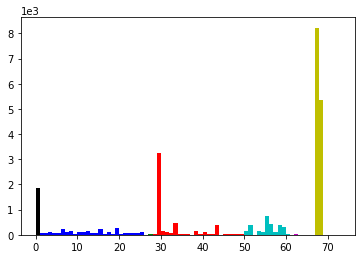

In [23]:
weight = [combined_act_counter[i] for i in tups]
_, _, patches = plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)))

#Applying colors
for j,t in enumerate(tups[:-1]):
    if type(t) == int:
        continue
    patches[j].set_facecolor(colormap[t[0]])
patches[0].set_facecolor(colormap[-1])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

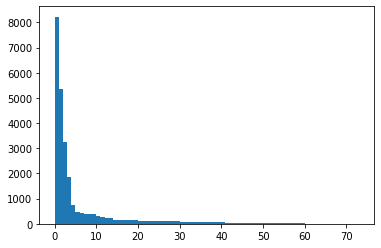

In [24]:
weight = [c for v,c in counters[-1]['set_hash'].most_common()]
_, _, patches = plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)))

#Applying colors
#patches[0].set_facecolor(colormap[-1])
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

In [25]:
print('Total:',
    len(combined_act_counter.most_common()),
      entropy(list(combined_act_counter.values())))
print('Group 1:',
      len(act_counter_group1.most_common()),
      entropy(list(act_counter_group1.values())))
print('Group 2:',
      len(act_counter_group2.most_common()),
      entropy(list(act_counter_group2.values())))

Total: 74 2.511363531402685
Group 1: 74 2.511363531402685
Group 2: 0 0.0


/home/matthijs/Software/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


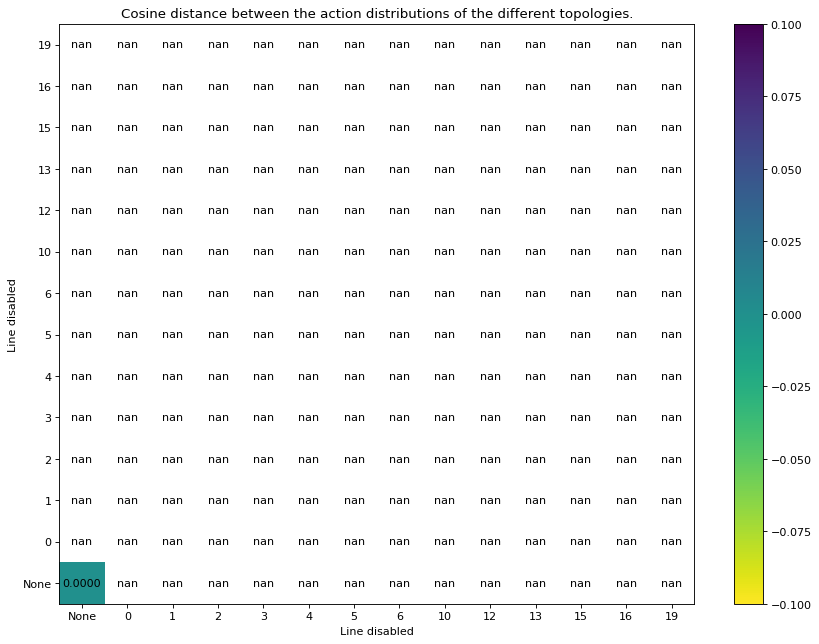

In [26]:
plt.figure(figsize=[2*6.4, 2*4.8], dpi=80)

data = np.random.rand(len(line_disabled_to_consider), len(line_disabled_to_consider))
for iy,y in enumerate([counters[i]['unique_set_act'] for i in line_disabled_to_consider]):
    for ix,x in enumerate([counters[i]['unique_set_act'] for i in line_disabled_to_consider]):
        cosine = distance.cosine([y[a] for a in combined_act_counter.keys()],
                                     [x[a] for a in combined_act_counter.keys()])
        data[iy,ix] = cosine
heatmap = plt.pcolor(data,cmap='viridis_r')

for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % data[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

plt.colorbar(heatmap)
plt.xticks(np.arange(0.5,len(line_disabled_to_consider)+0.5),['None']+line_disabled_to_consider[1:])
plt.yticks(np.arange(0.5,len(line_disabled_to_consider)+0.5),['None']+line_disabled_to_consider[1:])
plt.ylabel('Line disabled')
plt.xlabel('Line disabled')
plt.title('Cosine distance between the action distributions of the different topologies.')
plt.savefig('data_preprocessing_analysis/figures/cosine_distance_actions.png', dpi=300)
plt.show()

In [27]:
(len(combined_act_counter.most_common()),entropy(list(combined_act_counter.values())))

(74, 2.511363531402685)

### Topology Distribution

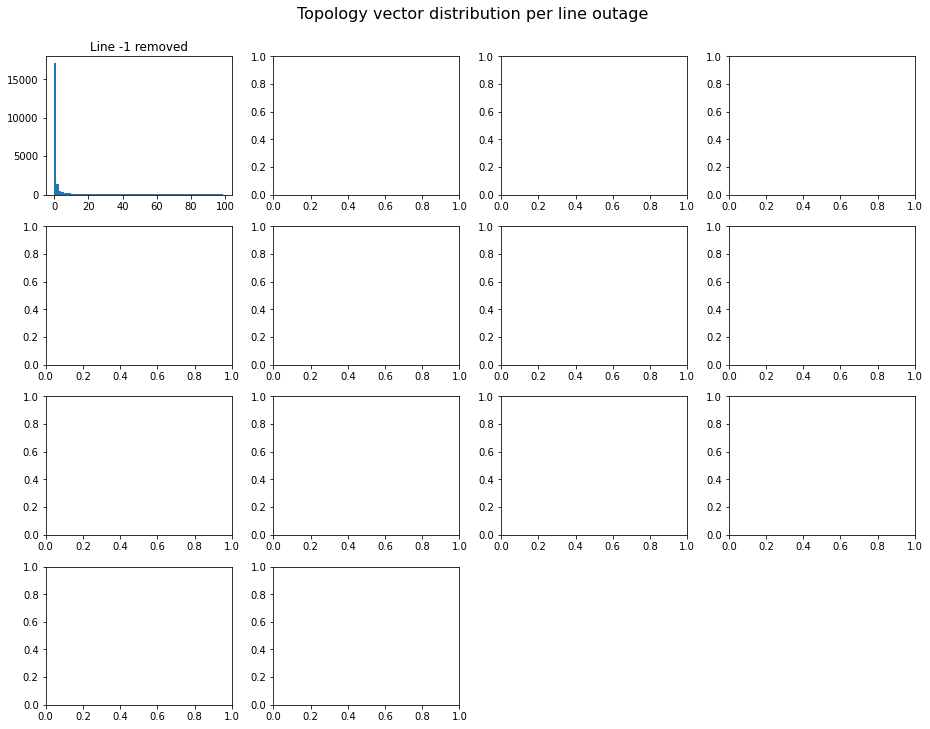

In [28]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
axs = axs.reshape(-1)
fig.tight_layout()
for plt_i, c_i in enumerate(line_disabled_to_consider):
    res_counter = counters[c_i]['tv_hash']
    if not res_counter:
        continue
    val, weight = zip(*[(i, v) for i,(k,v) in enumerate(res_counter.most_common())])
    axs[plt_i].hist(val[0:100], weights=weight[0:100],bins=val[0:100])
    axs[plt_i].title.set_text(f'Line {c_i} removed')

for i in range(len(axs)-len(line_disabled_to_consider)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Topology vector distribution per line outage', fontsize=16, y=1.05)

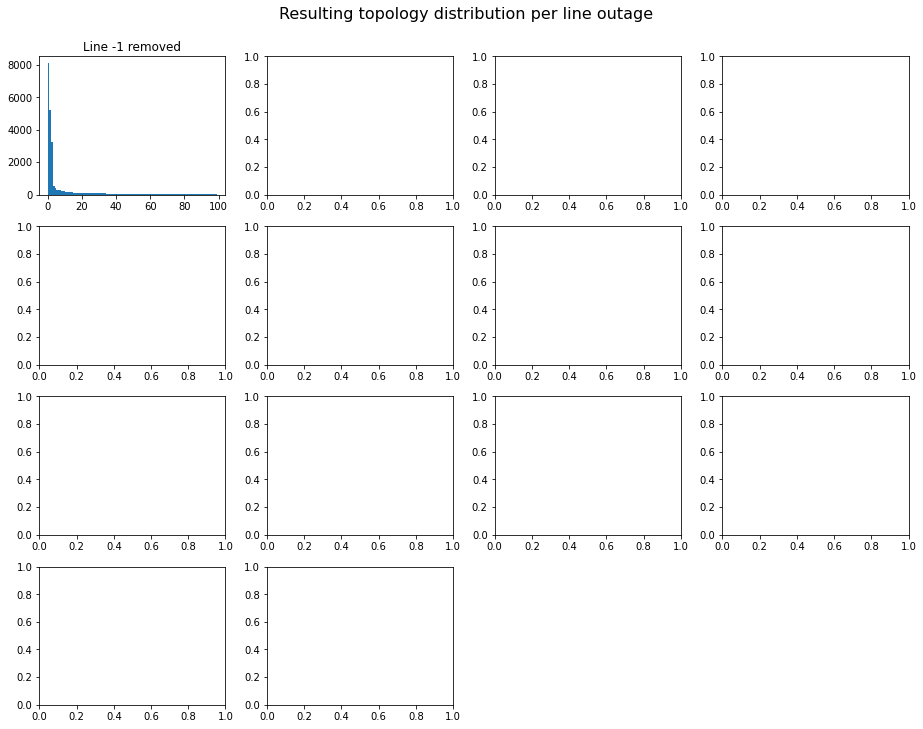

In [29]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
axs = axs.reshape(-1)
fig.tight_layout()
for plt_i, c_i in enumerate(line_disabled_to_consider):
    res_counter = counters[c_i]['res_hash']
    if not res_counter:
        continue
    val, weight = zip(*[(i, v) for i,(k,v) in enumerate(res_counter.most_common())])
    axs[plt_i].hist(val[0:100], weights=weight[0:100],bins=val[0:100])
    axs[plt_i].title.set_text(f'Line {c_i} removed')

for i in range(len(axs)-len(line_disabled_to_consider)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Resulting topology distribution per line outage', fontsize=16, y=1.05)

In [30]:
counters[-1]['res_hash'].most_common()

[(-2371491331546665287, 8138),
 (5386572753249518364, 5214),
 (6317564862595498276, 3248),
 (4904303365689970487, 518),
 (4855715301638168595, 372),
 (-9056524000618512985, 306),
 (-395344662178469635, 290),
 (-9111461443358445998, 251),
 (4685955545193298480, 236),
 (-285387819353293985, 203),
 (-6839882859416212019, 180),
 (-4303282635900150433, 177),
 (3050483041832376145, 176),
 (4911537273326997673, 155),
 (-5609535194072049939, 152),
 (3114593943089378161, 122),
 (8510601487935428715, 117),
 (-7514919894228579137, 112),
 (5236742253121396515, 106),
 (5238650007882883096, 96),
 (-2735827949372481379, 93),
 (-6581822670659128010, 92),
 (8327128964265188951, 89),
 (7393666916449921139, 86),
 (6153670354481608650, 83),
 (5654471766411172460, 81),
 (7108348183546709068, 78),
 (-7215229277839124302, 76),
 (5056750769011404667, 71),
 (-9064895108731978531, 70),
 (-8736683849198326796, 68),
 (2306950141887893649, 67),
 (-2644174065410745222, 66),
 (-1721487459425244455, 62),
 (-595362996

### Substations acted on

In [31]:
substations_with_actions = [1,2,3,4,5,8,12,-1]

In [32]:
np.array(counters[c_i]['sub_changed'])[substations_with_actions]

array([0, 0, 0, 0, 0, 0, 0, 0])

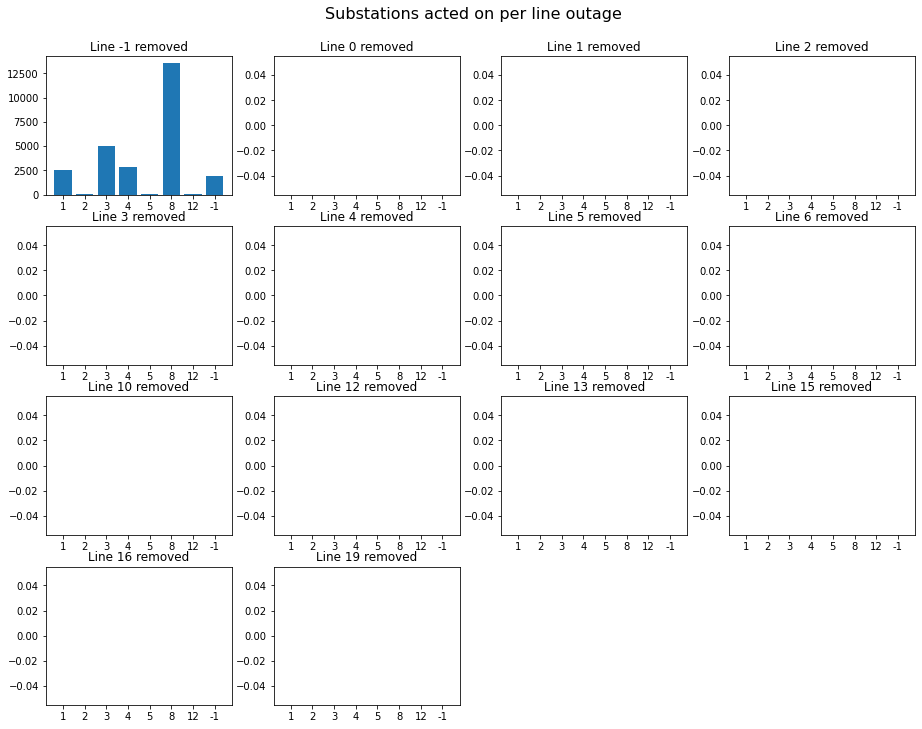

In [33]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
axs = axs.reshape(-1)
fig.tight_layout()
for plt_i, c_i in enumerate(line_disabled_to_consider):
    axs[plt_i].bar([str(b) for b in substations_with_actions],
                   np.array(counters[c_i]['sub_changed'])[substations_with_actions])
    axs[plt_i].title.set_text(f'Line {c_i} removed')

for i in range(len(axs)-len(line_disabled_to_consider)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Substations acted on per line outage', fontsize=16, y=1.05)

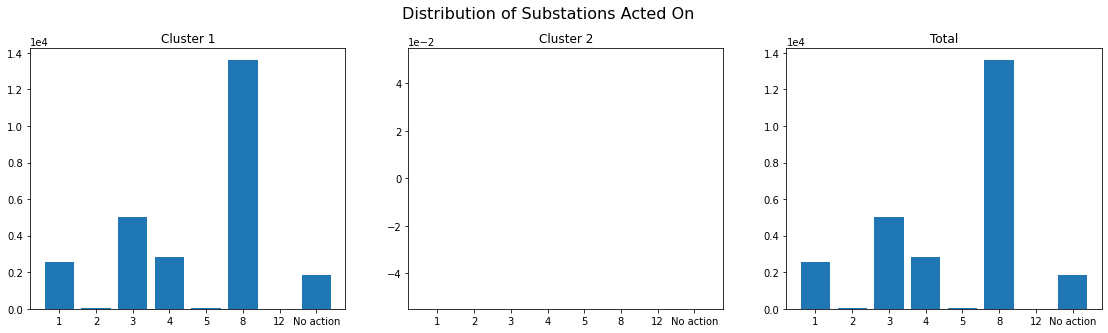

In [34]:
fig, axs = plt.subplots(1,3,figsize=[3*6.4, 1*4.8])

axs[0].bar([str(l) for l in substations_with_actions[:-1]] + ['No action'],
        np.sum(np.array([counters[c_i]['sub_changed'] \
                                                   for c_i in line_group1]),axis=0)[substations_with_actions])
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[0].set_title('Cluster 1')

axs[1].bar([str(l) for l in substations_with_actions[:-1]] + ['No action'],
        np.sum(np.array([counters[c_i]['sub_changed'] \
                                                   for c_i in line_group2]),axis=0)[substations_with_actions])
axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[1].set_title('Cluster 2')

axs[2].bar([str(l) for l in substations_with_actions[:-1]] + ['No action'],
        np.sum(np.array([counters[c_i]['sub_changed'] \
                                                   for c_i in line_disabled_to_consider]),axis=0)[substations_with_actions])
axs[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[2].set_title('Total')

fig.suptitle('Distribution of Substations Acted On', fontsize=16, y=1)
fig.savefig('data_preprocessing_analysis/figures/distribution_substations.png', dpi=300)

### Topological Depth

In [35]:
do_nothing_action_hashes = [h for h,t in hash_to_act.items() if sum(t)==0]
def mean_index(lst):
    return np.sum(np.array([i*v for i,v in enumerate(lst)]))/sum(lst)
[(k,mean_index(v['changed_subs_n']))
 for k,v in counters.items() if k in line_disabled_to_consider]

<ipython-input-35-a35de823d72d>:3: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum(np.array([i*v for i,v in enumerate(lst)]))/sum(lst)


[(-1, 1.4628938560381641),
 (0, nan),
 (1, nan),
 (2, nan),
 (3, nan),
 (4, nan),
 (5, nan),
 (6, nan),
 (10, nan),
 (12, nan),
 (13, nan),
 (15, nan),
 (16, nan),
 (19, nan)]

mean topological depth

In [36]:
print('Total:',
    mean_index(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in line_disabled_to_consider ]),axis=0)))
print('Group 1:',
      mean_index(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in line_group1 ]),axis=0)))
print('Group 2:',
    mean_index(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in line_group2 ]),axis=0)))

Total: 1.4628938560381641
Group 1: 1.4628938560381641
Group 2: nan


<ipython-input-35-a35de823d72d>:3: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum(np.array([i*v for i,v in enumerate(lst)]))/sum(lst)


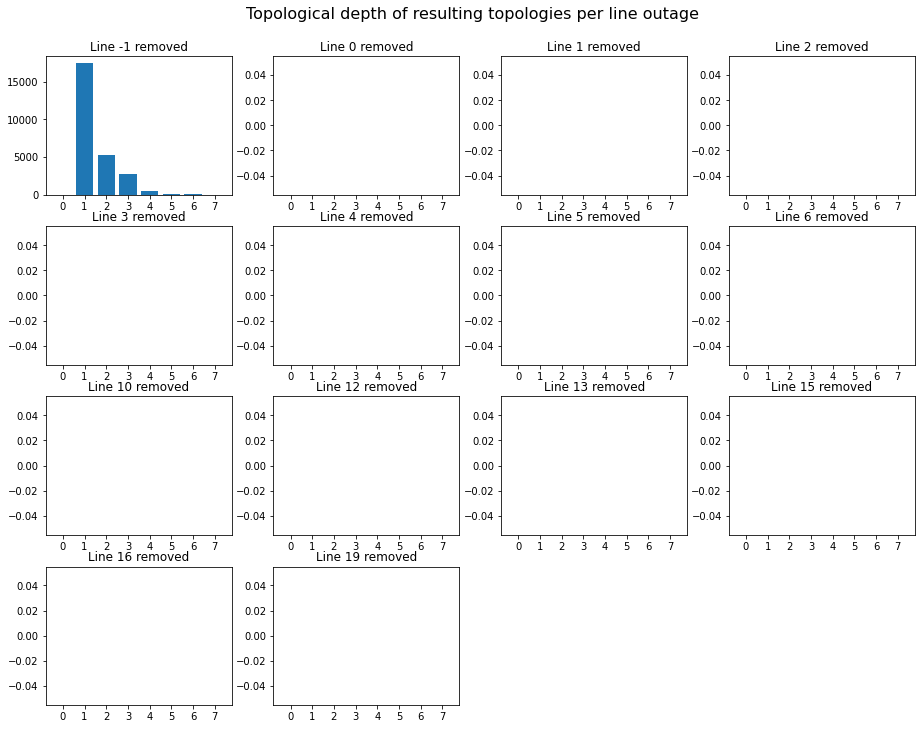

In [37]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
axs = axs.reshape(-1)
fig.tight_layout()
for plt_i, c_i in enumerate(line_disabled_to_consider):
    axs[plt_i].bar([str(n) for n in range(len(substations_with_actions))],
                   counters[c_i]['changed_subs_n'][0:len(substations_with_actions)])
    axs[plt_i].title.set_text(f'Line {c_i} removed')

for i in range(len(axs)-len(line_disabled_to_consider)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Topological depth of resulting topologies per line outage', fontsize=16, y=1.05)

Text(0.5, 1.0, '')

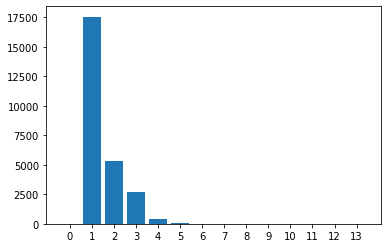

In [38]:
plt.bar([str(n) for n in range(n_sub)],np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                        for c_i in np.arange(-1,20)]),axis=0))
plt.title('')

In [ ]:
fig, axs = plt.subplots(1,3,figsize=[3*6.4, 1*4.8])

axs[0].bar(range(len(substations_with_actions)),
        np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                   for c_i in line_group1]),axis=0)[0:8])
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[0].set_title('Cluster 1')

axs[1].bar(range(len(substations_with_actions)),
        np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                   for c_i in line_group2]),axis=0)[0:8])
axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[1].set_title('Cluster 2')

axs[2].bar(range(len(substations_with_actions)),
        np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                   for c_i in line_disabled_to_consider]),axis=0)[0:8])
axs[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[2].set_title('Total')


fig.suptitle('Distribution of Topological Depth of Actions', fontsize=16, y=1)
fig.savefig('data_preprocessing_analysis/figures/distribution_topological_depth.png', dpi=300)
#TODO: remove susbtations that never have any actions

# Sequence data analysis on unprocessed data

In [137]:
util.set_wd_to_package_root()
config = util.load_config()
tutor_data_path = config['paths']['tutor_imitation']
ts_in_day = config['rte_case14_realistic']['ts_in_day']

line_disabled_to_consider = [-1,0,1,2,3,4,5,6,10,12,13,15,16,19]
line_group1 = [-1,0,1,2,3,4,5,6,12]
line_group2 = [13,15,16,19]

In [182]:
unitary_action_counter = Counter()
sequence_length_counter = Counter()
sequence_counter = Counter()
action_ider = action_identificator()

for fp in tqdm(idp.get_filepaths(tutor_data_path)):
    line_disabled, _, _, _ = idp.extract_data_from_filepath(fp.relative_to(tutor_data_path))
    
    if line_disabled not in line_disabled_to_consider:
        continue
    
    
    
    # Load a single file with raw datapoints
    chr_ldis_raw_dps = np.load(fp)
    
    # Define a sequence data object
    sequence = []
    subs_already_acted_on_in_sequence = []
    # Loop over datapoints
    for action_idx, timestep in chr_ldis_raw_dps[:,(0,4)]:

        
        action_idx = int(action_idx)
        timestep  = int(timestep)
        set_action = action_ider.get_set_topo_vect(action_idx)
        action_subid = util.argmax_f(g2o_util.tv_groupby_subst(set_action,
                                                               [3, 6, 4, 6, 5, 6, 3, 2, 5, 3, 3, 3, 4, 3]),
                                     sum)
        
        unitary_action_counter[action_idx] += 1
        
        # If, terminiation condition for a sequence: 
        #     The action is a do-nothing action OR 
        #     two timesteps are not consecutive OR
        #     two timesteps are not in the same day
        # then save the sequence (if it is not empty), and reset the sequence
        if (action_idx == -1 or
           (sequence and (sequence[-1][1] != timestep-1 or
                          g2o_util.ts_to_day(sequence[-1][1], ts_in_day) != g2o_util.ts_to_day(timestep, ts_in_day)) or
           action_subid in subs_already_acted_on_in_sequence)):
            
            # Save the sequence if not empty
            if sequence:
                sequence_length_counter[len(sequence)] += 1
                
            
            if len(sequence)>-1:
                sequence_actions = [a for a,ts in sequence]
                sequence_counter[tuple(sequence_actions)] += 1
                
            # Reset the sequence
            if action_idx == -1:
                sequence = []
                subs_already_acted_on_in_sequence = []
            else:
                sequence = [(action_idx, timestep)]
                subs_already_acted_on_in_sequence = [action_subid]
                
        # Else, if the action is not do-nothing, add it to the sequence
        elif action_idx != -1:
            sequence.append((action_idx, timestep))
            subs_already_acted_on_in_sequence.append(action_subid)
        else:
            assert False, 'Either of above conditions should be true: this statement should not be reached'

100%|██████████| 997/997 [00:05<00:00, 195.88it/s]


In [183]:
sequence_counter

Counter({(96,): 11977,
         (28,): 5036,
         (31,): 3476,
         (96, 33): 710,
         (38,): 5790,
         (96, 38): 1323,
         (44,): 1389,
         (33,): 3924,
         (37,): 1154,
         (28, 61): 181,
         (64,): 975,
         (61,): 888,
         (64, 31, 6): 10,
         (24, 52): 67,
         (0,): 21,
         (5,): 19,
         (49,): 768,
         (53,): 284,
         (11,): 66,
         (1,): 35,
         (33, 9): 1,
         (54,): 154,
         (6,): 2275,
         (24,): 2107,
         (13,): 504,
         (31, 6): 137,
         (24, 28): 184,
         (63,): 43,
         (47, 57): 1,
         (2,): 205,
         (6, 52): 122,
         (42, 9): 21,
         (9,): 49,
         (24, 31): 10,
         (6, 28): 75,
         (52,): 493,
         (46,): 226,
         (40,): 211,
         (47,): 161,
         (61, 96): 38,
         (30,): 70,
         (): 527,
         (14, 61): 5,
         (64, 29): 3,
         (57,): 2,
         (55,): 218,
         

Sequence length distribution

Text(0.5, 1.0, 'Sequence length distribution')

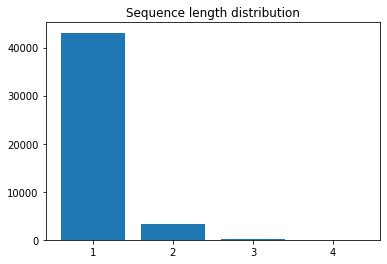

In [184]:
max_sequence_length = max(sequence_length_counter.keys())
rnge = np.arange(1,max_sequence_length)
plt.bar([str(i) for i in rnge], 
        [sequence_length_counter[i] for i in rnge])
plt.title("Sequence length distribution")

In [185]:
[(i,sequence_length_counter[i]/sequence_length_counter[i-1]) for i in np.arange(2,max_sequence_length) 
 if sequence_length_counter[i-1] != 0]

[(2, 0.07568972318258811), (3, 0.030656039239730228), (4, 0.0)]

In [186]:
sequence_counter.most_common()

[((96,), 11977),
 ((38,), 5790),
 ((28,), 5036),
 ((33,), 3924),
 ((31,), 3476),
 ((6,), 2275),
 ((24,), 2107),
 ((44,), 1389),
 ((96, 38), 1323),
 ((37,), 1154),
 ((64,), 975),
 ((61,), 888),
 ((49,), 768),
 ((96, 33), 710),
 ((), 527),
 ((13,), 504),
 ((52,), 493),
 ((53,), 284),
 ((46,), 226),
 ((55,), 218),
 ((40,), 211),
 ((2,), 205),
 ((24, 28), 184),
 ((28, 61), 181),
 ((47,), 161),
 ((54,), 154),
 ((31, 6), 137),
 ((6, 52), 122),
 ((58,), 106),
 ((6, 28), 75),
 ((30,), 70),
 ((24, 52), 67),
 ((11,), 66),
 ((64, 31), 65),
 ((42,), 63),
 ((29,), 60),
 ((9,), 49),
 ((14,), 49),
 ((63,), 43),
 ((61, 96), 38),
 ((1,), 35),
 ((21,), 35),
 ((100,), 35),
 ((18,), 32),
 ((19,), 30),
 ((10,), 26),
 ((28, 61, 96), 26),
 ((61, 31), 23),
 ((0,), 21),
 ((42, 9), 21),
 ((5,), 19),
 ((12,), 19),
 ((62,), 18),
 ((24, 28, 61), 18),
 ((11, 55), 16),
 ((42, 24), 16),
 ((41,), 16),
 ((59,), 13),
 ((42, 55), 13),
 ((17,), 13),
 ((52, 61), 12),
 ((28, 55), 11),
 ((64, 42), 11),
 ((64, 31, 6), 10),
 (

Inspecting sequence distributions for sequences larger than one

Text(0.5, 1.0, 'Distribution of sequence frequency for frequencies longer than one')

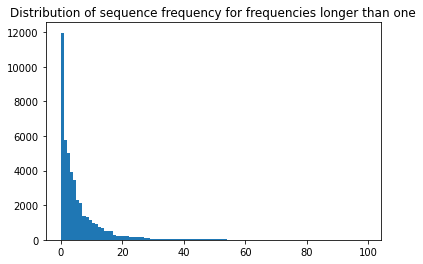

In [178]:
weight = [n for _,n in sequence_counter.most_common()][0:100]
plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)))
plt.title("Distribution of sequence frequency for frequencies longer than one")

In [179]:
set_seq_counter.most_common()

[((96, 38), 1323),
 ((96, 33), 710),
 ((24, 28), 184),
 ((28, 61), 181),
 ((6, 31), 137),
 ((52, 6), 122),
 ((28, 6), 75),
 ((24, 52), 67),
 ((64, 31), 65),
 ((96, 61), 38),
 ((96, 28, 61), 26),
 ((9, 42), 24),
 ((61, 31), 23),
 ((24, 28, 61), 18),
 ((24, 42), 17),
 ((11, 55), 16),
 ((42, 55), 13),
 ((52, 61), 12),
 ((28, 55), 11),
 ((64, 42), 11),
 ((24, 31), 11),
 ((64, 6, 31), 10),
 ((64, 52), 9),
 ((52, 14), 8),
 ((97, 52), 6),
 ((1, 53), 6),
 ((61, 14), 5),
 ((11, 38), 5),
 ((18, 47), 5),
 ((24, 52, 61), 5),
 ((54, 52, 6), 4),
 ((49, 6), 4),
 ((49, 13), 4),
 ((40, 6), 4),
 ((64, 28), 4),
 ((1, 28), 4),
 ((64, 29), 3),
 ((64, 24, 42), 3),
 ((52, 54), 3),
 ((64, 13), 3),
 ((9, 55), 3),
 ((64, 18, 47), 3),
 ((24, 55), 3),
 ((64, 49), 3),
 ((24, 97), 3),
 ((24, 49), 3),
 ((62, 52, 6), 3),
 ((2, 31), 3),
 ((96, 57), 3),
 ((19, 38), 3),
 ((49, 26), 2),
 ((33, 58), 2),
 ((28, 102), 2),
 ((10, 28), 2),
 ((9, 47), 2),
 ((18, 46), 2),
 ((64, 14), 2),
 ((33, 55), 2),
 ((1, 38), 2),
 ((52, 6,

Inspecting sequences including permutations

Text(0.5, 1.0, 'Distribution of sequence frequency for frequencies longer than one')

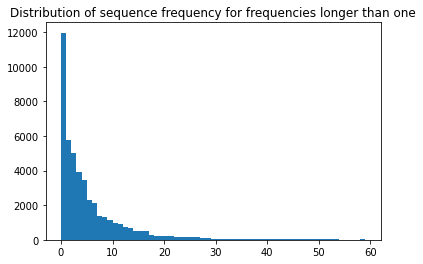

In [180]:
set_seq_counter = Counter()
for seq,n in sequence_counter.most_common():
    set_seq_counter[tuple(set(seq))] += n
weight = [n for _,n in set_seq_counter.most_common()][0:60]
plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)))
plt.title("Distribution of sequence frequency for frequencies longer than one")

Inspecting sequences including permutations of all sizes


Text(0.5, 1.0, 'Distribution of sequence frequency for frequencies longer than one')

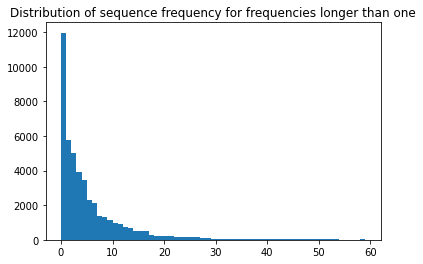

In [181]:
set_seq_counter = Counter()
for seq,n in sequence_counter.most_common():
    set_seq_counter[tuple(set(seq))] += n
weight = [n for _,n in set_seq_counter.most_common()][0:60]
plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)))
plt.title("Distribution of sequence frequency for frequencies longer than one")

Frequent action analysis

In [153]:
frequent_actions = [a for a,c in unitary_action_counter.most_common() if c>1000]
frequent_actions

[96, 38, 28, 33, 31, 6, 24, 44, 61, 37, 64]

In [154]:
n_freq_action_by_sequence_length_counter = Counter()
for seq, n in sequence_counter.items():
    for act in seq:
        n_freq_action_by_sequence_length_counter[len(seq)] += n if act in frequent_actions else 0

<ipython-input-155-0fe958cd4b49>:2: RuntimeWarning: invalid value encountered in true_divide
  perc_freq_act_per_seq_len = np.array([n_freq_action_by_sequence_length_counter[i] for i in rng])/np.array([sequence_length_counter[i]*i for i in rng])


Text(0, 0.5, 'Percentage of frequent actions')

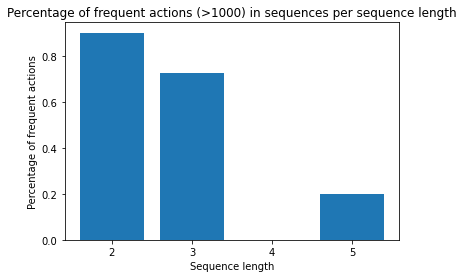

In [155]:
rng = np.arange(2,6)
perc_freq_act_per_seq_len = np.array([n_freq_action_by_sequence_length_counter[i] for i in rng])/np.array([sequence_length_counter[i]*i for i in rng])
plt.bar([str(i) for i in rng],perc_freq_act_per_seq_len)
plt.title('Percentage of frequent actions (>1000) in sequences per sequence length')
plt.xlabel('Sequence length')
plt.ylabel('Percentage of frequent actions')

In [156]:
rng = np.arange(2,6)

In [157]:
rng

array([2, 3, 4, 5])

In [158]:
sequence_length_counter

Counter({1: 43097, 2: 3262, 3: 100, 5: 1})